In [2]:
# load modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load
pdb=('mpro.pdb')
traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro05.dcd','mpro06.dcd']
feat=pyemma.coordinates.featurizer(pdb)
selstr="resSeq 3 4 5 6 84 135 141 164 167 171 175 178 179 180 190 195 217 284 285 286 290 291 300 301"
feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
data_dih=pyemma.coordinates.load(traj, features=feat)
data_dih_c=np.concatenate(data_dih)

100%|██████████| 6/6 [00:00<00:00, 18.67it/s]                                 


In [5]:
feat.describe()

['COS(PHI 0 PHE 3)',
 'SIN(PHI 0 PHE 3)',
 'COS(PSI 0 PHE 3)',
 'SIN(PSI 0 PHE 3)',
 'COS(PHI 0 ARG 4)',
 'SIN(PHI 0 ARG 4)',
 'COS(PSI 0 ARG 4)',
 'SIN(PSI 0 ARG 4)',
 'COS(PHI 0 LYS 5)',
 'SIN(PHI 0 LYS 5)',
 'COS(PSI 0 LYS 5)',
 'SIN(PSI 0 LYS 5)',
 'COS(PHI 0 MET 6)',
 'SIN(PHI 0 MET 6)',
 'COS(PSI 0 MET 6)',
 'SIN(PSI 0 MET 6)',
 'COS(PHI 0 ASN 84)',
 'SIN(PHI 0 ASN 84)',
 'COS(PSI 0 ASN 84)',
 'SIN(PSI 0 ASN 84)',
 'COS(PHI 0 THR 135)',
 'SIN(PHI 0 THR 135)',
 'COS(PSI 0 THR 135)',
 'SIN(PSI 0 THR 135)',
 'COS(PHI 0 LEU 141)',
 'SIN(PHI 0 LEU 141)',
 'COS(PSI 0 LEU 141)',
 'SIN(PSI 0 LEU 141)',
 'COS(PHI 0 HIS 164)',
 'SIN(PHI 0 HIS 164)',
 'COS(PSI 0 HIS 164)',
 'SIN(PSI 0 HIS 164)',
 'COS(PHI 0 LEU 167)',
 'SIN(PHI 0 LEU 167)',
 'COS(PSI 0 LEU 167)',
 'SIN(PSI 0 LEU 167)',
 'COS(PHI 0 VAL 171)',
 'SIN(PHI 0 VAL 171)',
 'COS(PSI 0 VAL 171)',
 'SIN(PSI 0 VAL 171)',
 'COS(PHI 0 THR 175)',
 'SIN(PHI 0 THR 175)',
 'COS(PSI 0 THR 175)',
 'SIN(PSI 0 THR 175)',
 'COS(PHI 0 GLU 178)',
 

In [20]:
##Ο πίνακας που προκύπτει από την προηγούμενη ανάλυση
import pandas as pd
data = pd.read_csv('df.txt', sep=",")
data

,Unnamed: 0,IC1,IC2,IC3,pos,a.a,sin/cos,phi/psi
0,0,0.222455,-0.288424,-0.075114,3,PHE,COS,PHI
1,1,-0.167333,0.181811,0.104695,3,PHE,SIN,PHI
2,2,0.143228,-0.467745,-0.341650,3,PHE,COS,PSI
3,3,0.200887,-0.548390,-0.424974,3,PHE,SIN,PSI
4,4,0.199367,-0.355311,-0.339336,4,ARG,COS,PHI
...,...,...,...,...,...,...,...,...
91,91,-0.297391,0.337564,-0.130704,300,CYS,SIN,PSI
92,92,-0.103867,0.074726,0.025310,301,SER,COS,PHI
93,93,-0.019618,-0.049279,-0.049867,301,SER,SIN,PHI
94,94,-0.069346,0.136679,-0.147939,301,SER,COS,PSI


In [25]:
np.shape(data_dih_c[:, 2])

(13212,)

In [36]:
###Calculate points in the new CV space
##IC1
IC1 = 0
for i in range(len(data)):
    IC1  += data['IC1'][i]*data_dih_c[:,i]
print(IC1) 

[-5.577264  -5.577262  -4.1023407 ... -4.292765  -3.955801  -3.4019148]


In [37]:
##IC2
IC2 = 0
for i in range(len(data)):
    IC2 += data['IC2'][i]*data_dih_c[:,i]
print(IC2) 

[4.0913005  4.091313   3.137839   ... 0.18756412 0.7135964  0.08222561]


In [38]:
tica_output=np.transpose([IC1,IC2])

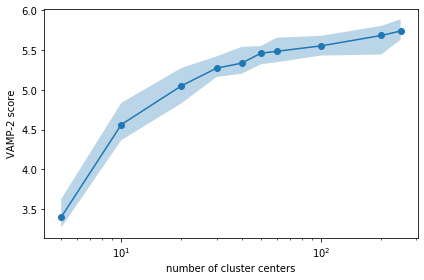

In [44]:
n_clustercenters = [5, 10, 20, 30, 40, 50, 60, 100, 200, 250]

scores = np.zeros((len(n_clustercenters), 10))
for n, k in enumerate(n_clustercenters):
    for m in range(10):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=200, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 10)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

100%|██████████| 14/14 [00:04<00:00,  3.11it/s]                        


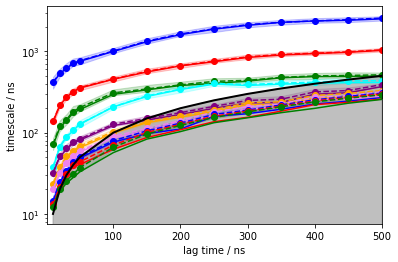

In [47]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=100, max_iter=100, stride=10, fixed_seed=100)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], nits=10, errors='bayes')
fig1 = pyemma.plots.plot_implied_timescales(its, units='ns', dt=1)

3072it [00:00, 22294.11it/s]                                                                                                              
100%|██████████| 9/9 [00:07<00:00,  1.22it/s]                        


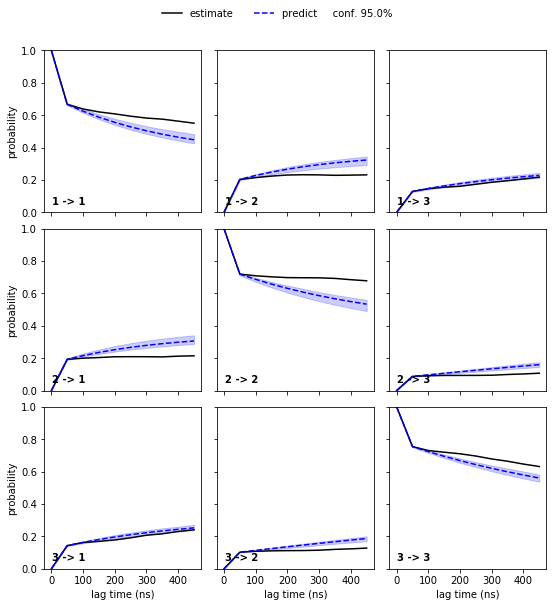

In [48]:
nstates=3
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
fig2 = pyemma.plots.plot_cktest(msm.cktest(nstates), units='ns');

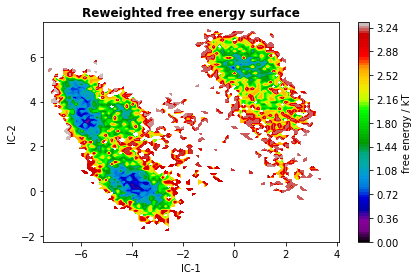

In [49]:
# MSM Free Energy
fig3, ax = pyemma.plots.plot_free_energy(
    *tica_output[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()))
ax.set_xlabel('IC-1')
ax.set_ylabel('IC-2')
ax.set_title('Reweighted free energy surface', fontweight='bold')
fig3.tight_layout()

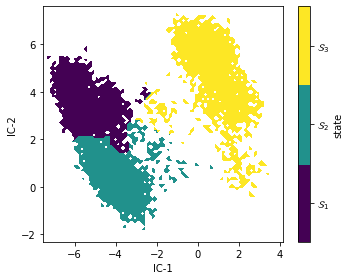

In [50]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig4, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_output[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC-1')
ax.set_ylabel('IC-2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig4.tight_layout()

π_1 = 0.341345
π_2 = 0.338169
π_3 = 0.320487


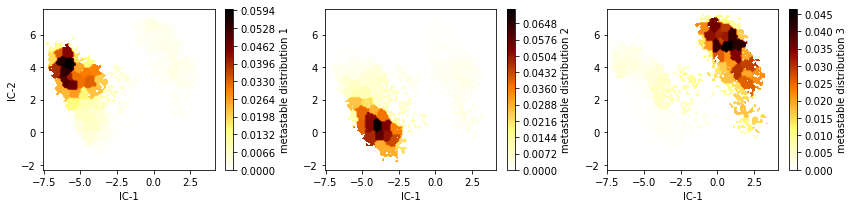

In [53]:
nstates = 3
msm.pcca(nstates)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_output.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC-1')
axes[0].set_ylabel('IC-2')
fig.tight_layout()

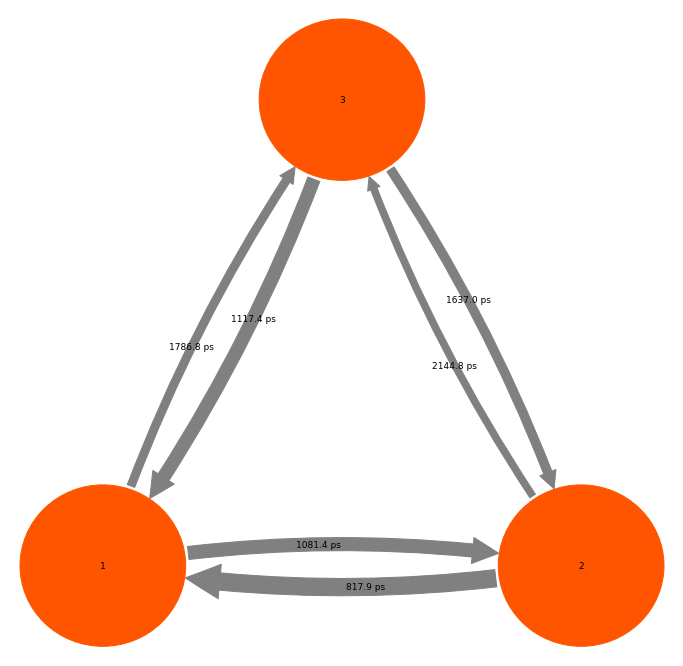

In [56]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=9);